<a href="https://colab.research.google.com/github/tasneemyo/Computer-Vision-Labs/blob/main/Assignment04/densenet_pet_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from torchvision.transforms.functional import to_pil_image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.v2 as v2
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pets-facial-expression-dataset


In [3]:
data_path=path+"/Master Folder"

In [4]:
val_test_transforms = v2.Compose([
    v2.Resize((224, 224), antialias=True), # resizing to the standard input size
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
train_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),  # Augmentation
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [6]:
train_dataset = datasets.ImageFolder(root=f"{data_path}/train", transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=f"{data_path}/valid", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=f"{data_path}/test",  transform=val_test_transforms)

In [7]:
print("Number of training images:", len(train_dataset))
print("Number of validation images:", len(valid_dataset))
print("Number of test images:", len(test_dataset))


Number of training images: 1000
Number of validation images: 36
Number of test images: 38


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [9]:
len(train_loader), len(valid_loader), len(test_loader)

(32, 2, 2)

In [10]:
for i, (inputs, labels) in enumerate(test_loader):
    print(f"Batch {i+1} size: {inputs.size(0)}")


Batch 1 size: 32
Batch 2 size: 6


In [11]:
print("Class labels:", train_dataset.classes)

Class labels: ['Angry', 'Other', 'Sad', 'happy']


In [12]:
images, labels = next(iter(test_loader))
print(images.shape)
print(images[0].shape)
print(labels)


torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3])


In [13]:
np.max(np.array(images[0]))

np.float32(0.96862745)

In [14]:
class_names=train_dataset.classes

In [15]:
num_classes = len(class_names)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **DenseNet 121**

https://medium.com/deepkapha-notes/implementing-densenet-121-in-pytorch-a-step-by-step-guide-c0c2625c2a60

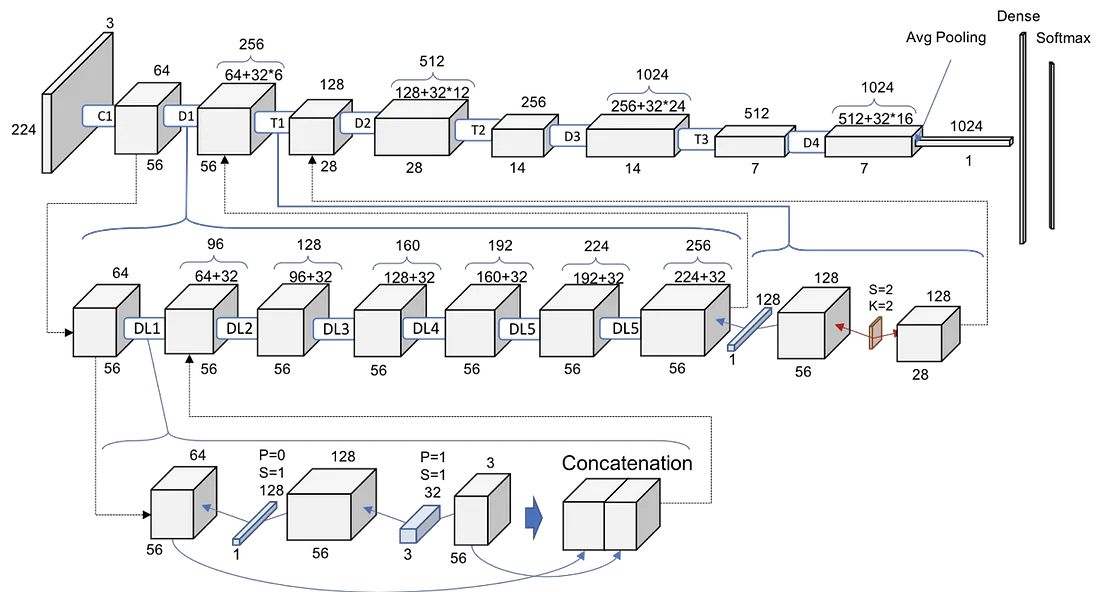

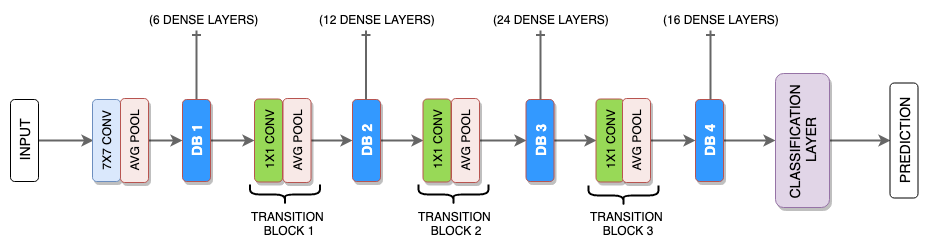

Notes:

- DenseBlock = x * DenseLayer
- DenseLayer = Conv1x1 + Conv3x3
- Conv = BatchNorm -> ReLU -> Conv



In [17]:
# 5. DenseNet121
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)

        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

        self.drop_rate = drop_rate

    def forward(self, x):
        out = self.conv1(self.relu1(self.norm1(x)))
        out = self.conv2(self.relu2(self.norm2(out)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        return torch.cat([x, out], 1)


In [18]:
class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
            )
            self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

- Transition: conv1x1 -> avg pooling 2x2 s=2

In [19]:
class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.norm(x)))
        x = self.pool(x)
        return x


In [20]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes=num_classes, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0):
        super().__init__()

        # initial conv
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # Dense blocks
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
            )
            self.features.add_module(f'denseblock{i+1}', block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module(f'transition{i+1}', trans)
                num_features = num_features // 2

        # final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # classific
        self.classifier = nn.Linear(num_features, num_classes)

        # weights init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [21]:
model = DenseNet121(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [22]:
# def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
#     best_acc = 0.0
#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch+1}/{num_epochs}')
#         print('-' * 10)

#         # Training phase
#         model.train()
#         running_loss = 0.0
#         running_corrects = 0

#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / len(train_dataset)
#         epoch_acc = running_corrects.double() / len(train_dataset)
#         print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#         # Validation phase
#         model.eval()
#         val_loss = 0.0
#         val_corrects = 0
#         all_preds = []
#         all_labels = []

#         with torch.no_grad():
#             for inputs, labels in valid_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)

#                 val_loss += loss.item() * inputs.size(0)
#                 val_corrects += torch.sum(preds == labels.data)
#                 all_preds.extend(preds.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())

#         val_loss = val_loss / len(valid_dataset)
#         val_acc = val_corrects.double() / len(valid_dataset)

#         # metrics
#         precision, recall, f1, _ = precision_recall_fscore_support(
#             all_labels, all_preds, average='weighted')

#         print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
#         print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

#         # best model
#         if val_acc > best_acc:
#             best_acc = val_acc
#             torch.save(model.state_dict(), 'best_densenet121.pth')

#     return model

import matplotlib.pyplot as plt  # <-- add this at the top of your script

def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    train_losses = []  # <-- added
    val_losses = []    # <-- added

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        train_losses.append(epoch_loss)  # <-- added
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(valid_dataset)
        val_acc = val_corrects.double() / len(valid_dataset)
        val_losses.append(val_loss)  # <-- added

        # metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted')

        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

        # best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_densenet121.pth')

    # <-- added
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model


Epoch 1/50
----------
Train Loss: 1.4779 Acc: 0.3180
Val Loss: 1.5574 Acc: 0.3056
Precision: 0.3393, Recall: 0.3056, F1: 0.2644
Epoch 2/50
----------
Train Loss: 1.3981 Acc: 0.3060
Val Loss: 1.7061 Acc: 0.2222
Precision: 0.2600, Recall: 0.2222, F1: 0.2045
Epoch 3/50
----------
Train Loss: 1.3730 Acc: 0.3270
Val Loss: 1.8627 Acc: 0.1944
Precision: 0.1840, Recall: 0.1944, F1: 0.1535
Epoch 4/50
----------
Train Loss: 1.3824 Acc: 0.3260
Val Loss: 1.5340 Acc: 0.3056
Precision: 0.3880, Recall: 0.3056, F1: 0.3210
Epoch 5/50
----------
Train Loss: 1.3826 Acc: 0.2920


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 1.5871 Acc: 0.1944
Precision: 0.0530, Recall: 0.1944, F1: 0.0833
Epoch 6/50
----------
Train Loss: 1.3611 Acc: 0.3500
Val Loss: 1.4918 Acc: 0.2500
Precision: 0.2521, Recall: 0.2500, F1: 0.2003
Epoch 7/50
----------
Train Loss: 1.3380 Acc: 0.3550
Val Loss: 1.8157 Acc: 0.2500
Precision: 0.2100, Recall: 0.2500, F1: 0.2147
Epoch 8/50
----------
Train Loss: 1.3391 Acc: 0.3700
Val Loss: 1.5122 Acc: 0.2500
Precision: 0.2552, Recall: 0.2500, F1: 0.2342
Epoch 9/50
----------
Train Loss: 1.3142 Acc: 0.4030
Val Loss: 1.4854 Acc: 0.3056
Precision: 0.2091, Recall: 0.3056, F1: 0.2467
Epoch 10/50
----------
Train Loss: 1.3501 Acc: 0.3520
Val Loss: 4.1547 Acc: 0.3333
Precision: 0.3140, Recall: 0.3333, F1: 0.2636
Epoch 11/50
----------
Train Loss: 1.2977 Acc: 0.3940
Val Loss: 1.8043 Acc: 0.2778
Precision: 0.1912, Recall: 0.2778, F1: 0.1817
Epoch 12/50
----------
Train Loss: 1.3250 Acc: 0.3700
Val Loss: 1.8790 Acc: 0.3333
Precision: 0.3808, Recall: 0.3333, F1: 0.3154
Epoch 13/50
----------
Tra

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 1.4602 Acc: 0.3333
Precision: 0.1907, Recall: 0.3333, F1: 0.2426
Epoch 17/50
----------
Train Loss: 1.2473 Acc: 0.4160
Val Loss: 2.5427 Acc: 0.2778
Precision: 0.4241, Recall: 0.2778, F1: 0.2701
Epoch 18/50
----------
Train Loss: 1.2692 Acc: 0.3980


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 2.1032 Acc: 0.2222
Precision: 0.1622, Recall: 0.2222, F1: 0.1865
Epoch 19/50
----------
Train Loss: 1.2520 Acc: 0.4060
Val Loss: 2.0763 Acc: 0.2778
Precision: 0.1895, Recall: 0.2778, F1: 0.2245
Epoch 20/50
----------
Train Loss: 1.2418 Acc: 0.4460
Val Loss: 1.7958 Acc: 0.3056
Precision: 0.4138, Recall: 0.3056, F1: 0.2874
Epoch 21/50
----------
Train Loss: 1.2412 Acc: 0.4220
Val Loss: 1.5405 Acc: 0.3056
Precision: 0.3203, Recall: 0.3056, F1: 0.2927
Epoch 22/50
----------
Train Loss: 1.2387 Acc: 0.4100
Val Loss: 2.9800 Acc: 0.2778
Precision: 0.1618, Recall: 0.2778, F1: 0.1993
Epoch 23/50
----------
Train Loss: 1.2178 Acc: 0.4480


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 1.6377 Acc: 0.2778
Precision: 0.2361, Recall: 0.2778, F1: 0.2387
Epoch 24/50
----------
Train Loss: 1.2615 Acc: 0.4220
Val Loss: 1.7963 Acc: 0.2778
Precision: 0.2905, Recall: 0.2778, F1: 0.2691
Epoch 25/50
----------
Train Loss: 1.2035 Acc: 0.4420
Val Loss: 1.5041 Acc: 0.3333
Precision: 0.3517, Recall: 0.3333, F1: 0.3356
Epoch 26/50
----------
Train Loss: 1.1934 Acc: 0.4530
Val Loss: 2.1233 Acc: 0.3056
Precision: 0.3611, Recall: 0.3056, F1: 0.3017
Epoch 27/50
----------
Train Loss: 1.2093 Acc: 0.4420
Val Loss: 1.5247 Acc: 0.3333
Precision: 0.3479, Recall: 0.3333, F1: 0.3389
Epoch 28/50
----------
Train Loss: 1.1988 Acc: 0.4540
Val Loss: 2.1935 Acc: 0.3056
Precision: 0.3047, Recall: 0.3056, F1: 0.2922
Epoch 29/50
----------
Train Loss: 1.2006 Acc: 0.4490
Val Loss: 2.1029 Acc: 0.3333
Precision: 0.4284, Recall: 0.3333, F1: 0.3000
Epoch 30/50
----------
Train Loss: 1.1939 Acc: 0.4540
Val Loss: 1.4566 Acc: 0.3056
Precision: 0.3030, Recall: 0.3056, F1: 0.2917
Epoch 31/50
----------

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 1.4916 Acc: 0.3056
Precision: 0.2101, Recall: 0.3056, F1: 0.2448
Epoch 37/50
----------
Train Loss: 1.1204 Acc: 0.4870
Val Loss: 2.5148 Acc: 0.2500
Precision: 0.1942, Recall: 0.2500, F1: 0.1950
Epoch 38/50
----------
Train Loss: 1.1883 Acc: 0.4690
Val Loss: 1.7465 Acc: 0.3333
Precision: 0.3042, Recall: 0.3333, F1: 0.3148
Epoch 39/50
----------
Train Loss: 1.0973 Acc: 0.5320
Val Loss: 1.6608 Acc: 0.3333
Precision: 0.3107, Recall: 0.3333, F1: 0.3185
Epoch 40/50
----------
Train Loss: 1.1231 Acc: 0.5210
Val Loss: 1.8356 Acc: 0.3333
Precision: 0.3317, Recall: 0.3333, F1: 0.3280
Epoch 41/50
----------
Train Loss: 1.0637 Acc: 0.5440
Val Loss: 2.0300 Acc: 0.2778
Precision: 0.2771, Recall: 0.2778, F1: 0.2717
Epoch 42/50
----------
Train Loss: 1.1087 Acc: 0.4960
Val Loss: 2.3921 Acc: 0.3056
Precision: 0.2689, Recall: 0.3056, F1: 0.2724
Epoch 43/50
----------
Train Loss: 1.0494 Acc: 0.5470
Val Loss: 1.7693 Acc: 0.2500
Precision: 0.3214, Recall: 0.2500, F1: 0.2220
Epoch 44/50
----------

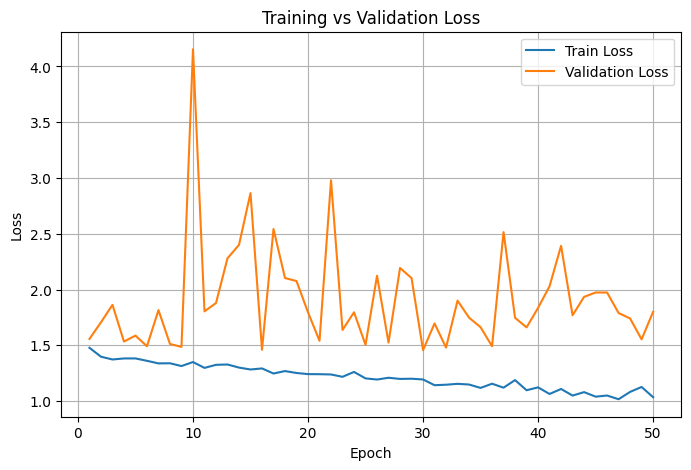

In [23]:
model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50)



In [24]:
# --- Evaluation Function ---
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = sum(1 for x,y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Test Accuracy: 0.5000
Precision: 0.4830
Recall: 0.5000
F1 Score: 0.4720


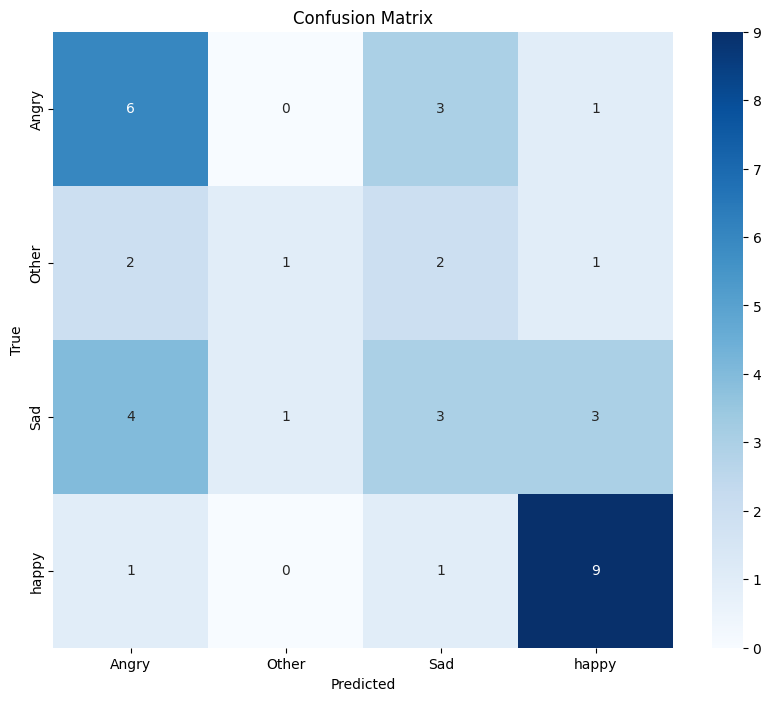

In [25]:
model.load_state_dict(torch.load('best_densenet121.pth'))
evaluate_model(model, test_loader)

------------------------------------------

## Transfer Learning